# Abnormal Group Mining Demo

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import distance

(0, 1)

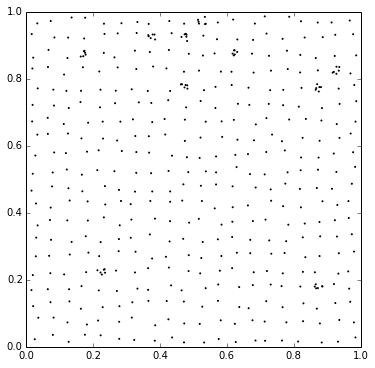

In [3]:
def generate_dataset(n=20, k=5, num_of_ag=10):
    # 将(0,1)x(0,1)划分成nxn个小格子，在格子的靠近中心位置生成一个点
    X = np.empty((n*n + num_of_ag*k, 2))
    X_1 = np.random.rand(n, n) * .5 + .25
    X_2 = np.random.rand(n, n) * .5 + .25
    ma, mb = np.meshgrid(xrange(n), xrange(n))
    ma = ma / float(n)
    mb = mb / float(n)
    X[:n*n, 0] = (X_1/n + ma).flatten()
    X[:n*n, 1] = (X_2/n + mb).flatten()
    # 生成num_of_ag特异群组点，每组含k个点
    for i in xrange(num_of_ag):
        X[n*n+i*k:n*n+(i+1)*k, :] = (np.random.rand(k, 2)*.5 + .25 
                                     + np.random.randint(0, n, size=(2,)))/n 
        
    return X

np.random.seed(0)
X = generate_dataset(20, 5, 10)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], s=1, alpha=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

In [4]:
def find_abnormal(X, threshold, updatecenter, metric='euclidean', maxiters=100):
    # Initiate centers
    centers = X[0, :][None, :]  # 初始中心只有一个即第一个样本
    backup = centers.copy() - 1  # 用来记录上一步的结果，判断是否收敛
    k = 0
    labels = np.zeros(len(X), dtype=int) # 每个样本所属类别
    loops = 0
    # interate until converged
    while len(backup) != len(centers) or not np.allclose(backup, centers):
        loops += 1
        backup = centers.copy()
        # 每一轮迭代都要遍历所有的点
        for i in xrange(len(X)):
            x = X[i, :]
            dis = distance.cdist([x], centers, metric=metric)[0]  # 计算与各中心的距离
            pos = dis.argmin()
            if dis[pos] > threshold:  # 如果最小的距离也大于阈值，则新建一个中心
                centers = np.concatenate((centers, x[None, :]))
                k += 1
                labels[i] = k
            else:  # 否则将这个点划到最近的中心点
                labels[i] = pos
        centers = updatecenter(X, centers, labels, k)  # 每轮最后都要更新中心点
        if loops > maxiters:
            break
    print 'iteration: %3d' % loops
    return centers, labels
    
def update_in_R2(X, centers, labels, k):
    # 这里的更新中心点只是简单的取均值
    count = np.zeros(k+1)
    centers_sum = np.zeros((k+1, 2))
    for i in xrange(len(X)):
        z = labels[i]
        count[z] += 1
        centers_sum[z, :] += X[i, :]
    return centers_sum / count[:, None]

In [5]:
def plot_in_R2(X, centers, labels, radius, minpts=2):
    # 最后大多数簇中只含有1个点，那么含有多于minpts个点的即为特异群组
    count = np.bincount(labels)
    ind = np.where(count >= minpts)[0]
    print 'Found %3d abnormal groups' % len(ind)
    print 'Number of pts in abnormal groups:\n %s' % count[ind]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.scatter(X[:,0], X[:,1], s=1, alpha=.5)
    for k in ind:
        cir = Circle(xy=tuple(centers[k]), radius=radius, alpha=.3)
        ax.add_patch(cir)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

iteration:   2
Found  10 abnormal groups
Number of pts in abnormal groups:
 [6 6 6 6 6 6 6 6 6 6]


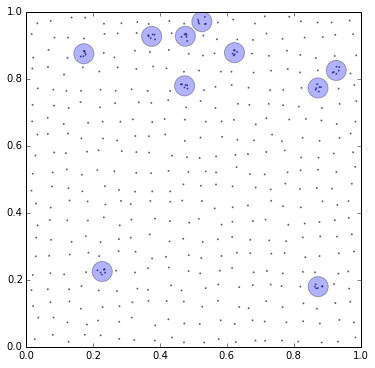

In [6]:
radius  = .03
centers, labels = find_abnormal(X, radius, update_in_R2)
plot_in_R2(X, centers, labels, radius, 3)